In [1]:
import spintrace

In [2]:
# # Initialize the downloader with CSV and output path
# downloader = spintrace.Downloader(
#     csv_file='Hektor/table_624-Hektor20000624.csv', # Path to your metadata file
#     path_to_save_fits='Hektor/fits_tables/',     # Folder to save the FITS files
#     max_workers=5,                               # Number of parallel downloads
#     verbose=False
# )

# downloader.download_fits()

2025-08-13 19:11:33,753 - INFO - Starting download of FITS files...
2025-08-13 19:11:35,261 - INFO - Download complete.


### If not known, you can retrieve some information from ssocard webpage using the following method.

Note that, if g-r colors are not provided, it calculates the values from other available colors, as follows:
- (g-i)-(r-i)
- (g-z)-(r-z)
- (v-r)-(v-g)

It calculates all three values with error bars, if they exist, and averages the results to print the inal value. 

In [3]:
info = spintrace.get_object_information_ssocard(target='Hektor')
info['color_indices']['r-i']

{'value': 0.2842,
 'error': 0.0053,
 'facility': 'SMSS',
 'filters': ['SkyMapper/SkyMapper.r', 'SkyMapper/SkyMapper.i'],
 'ref': 'Sergeyev+2022'}

In [4]:
fits_directory = 'Hektor/fits_tables/'
fits_files = spintrace.get_files(fits_directory)
colors = {'g-r': 0.61,'r-i':0.2842} # g-r from schemel et al 2021
color_errs = {'g-r': 0.01,'r-i':0.0053}
v_tol = 2

In [5]:
# The first time you run this cell will take a few minutes to download the ephemeris from JPL Horizons, but it saves it as .ephem_cache,
# so next runs will just read it from there. If you wanna force a new download you can set use_cache=False.
body = spintrace.Body(
    name="Hektor", 
    ephem_start_date="2018-01-01", 
    ephem_end_date="2025-07-01", 
    step="4h", 
    location="I41",
    use_cache=True)

In [6]:
# Here you initialize the class, to be able to perform the following calculations. 
mpa = spintrace.MultiPhotometryAnalysis(
    fits_files=fits_files,
    body=body,
    colors=colors,
    color_errs=color_errs,
    v_tol=v_tol
)

In [7]:
# This cell can take many minutes in your first run if check_close_stars=True. Because it will query Gaia catalog and return all Gaia stars inside a radius of 8" (default)
# It will save partial files every 100 queries in case something get wrong (e.g., you jupyter crashes), it will resume the download from the partial files. 
# Once it finishes, it will delete the partial file and save the final gaia_closeby_stars.fits files. It will use this file in next runs. 
mpa.run_analysis(check_close_stars=True)

2025-08-13 19:13:47,248 - INFO - Found existing Gaia stars final file: Hektor/gaia_closeby_stars.fits	 Skipping Gaia query and loading existing results...
2025-08-13 19:13:47,373 - INFO - Removing rows where a Gaia star is ≤ 4" from the asteroid's expected position.


Filtered table has 1089 rows after filtering.


In [9]:
# Initializes the PLots class
plots = spintrace.Plots(table = mpa.reduced_table,
                        ast_name=body.name,
                        fontsize=16)

In [10]:
string = f"{body.name}/plots/{body.name}"
string

'Hektor/plots/Hektor'

# General view and phase curve fitting in each filter

In [11]:
f_list = ['g','r','i'] # Filters that you might have data
string = 'Hektor/plots/Hektor' # the directory and start of file names to save the plots, first create the directory. 
phase_bin = int(2) # this is the value of solar phase angles to be use to bin data during the phase curve linear fit. 
# Binning helps to mitigate rotational amplitude effects in phase curve fit.
model = 'linear'# it could be shevchenko as well, linear is the default

for item in f_list:
    # creates the general plots of reduced mag as a function of time (JD corrected by light time).
    plots.general(filter_code=item,
              show_yerr=True,
              show_color=True,
              save_path=string+'_general_'+item+'.jpg')
    # Fit the phase curve and create the plots
    popt, fit_label, popt2, fit_label_binned = mpa.fit_phase_curve(filter_code=item,phase_bin=phase_bin,model=model)
    plots.phase_curve(filter_code=item,
                  popt=popt, 
                  fit_label=fit_label, 
                  popt2=popt2, 
                  fit_label_binned=fit_label_binned,
                  show_yerr=True,
                  show_color=True,
                  show_fig = False,
                  save_path=string+'_phase_curve_'+item+'_'+model+'.jpg')

Figure saved to Hektor/plots/Hektor_general_g.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_g_linear.jpg
Figure saved to Hektor/plots/Hektor_general_r.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_r_linear.jpg
Figure saved to Hektor/plots/Hektor_general_i.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_i_linear.jpg


In [13]:
# Here you will take a look in the Hektor_phase_curve*jpg files and decide which of the models' results you wanna use. 
# I usually take the binned values, but is good to look if the model is actually representing well your data, otherwise go back and change your phase_bin value
# Here you will generate a new table with reduced magnitude corrected by the solar phase effects.
table_g = mpa.fit_phase_curve(filter_code='g',model='linear',H=7.83,G=0.04)
table_i = mpa.fit_phase_curve(filter_code='i',model='linear',H=7.11,G=0.04)
table_r = mpa.fit_phase_curve(filter_code='r',model='linear',H=7.36,G=0.04)
from astropy.table import vstack
merged_table = vstack([table_g, table_r, table_i])
len(merged_table)

Fit result for g filter using original data and linear model:
Original data linear fit: H = 7.83, G = 0.04
Fit result for i filter using original data and linear model:
Original data linear fit: H = 7.11, G = 0.04
Fit result for r filter using original data and linear model:
Original data linear fit: H = 7.36, G = 0.04


1026

Figure saved to Hektor/plots/Hektor_corrected_by_phase.jpg


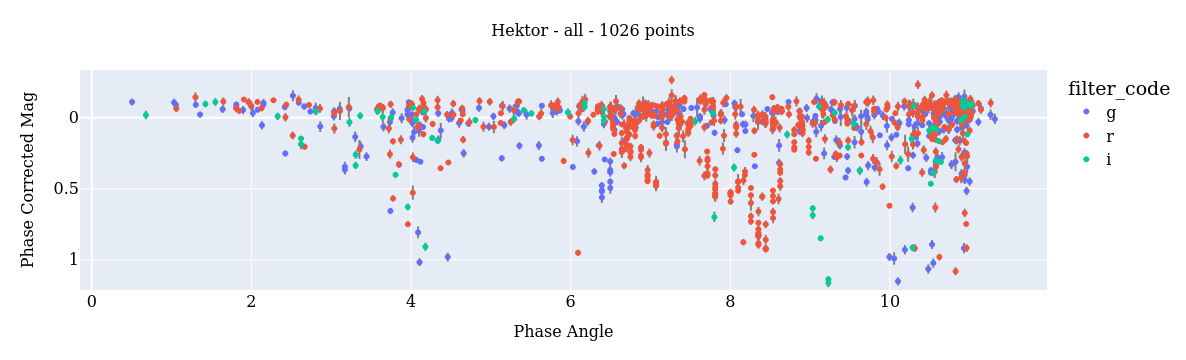

In [14]:
# Here is a plot to see if your linear fit worked for all the three filters. If they mismatch, you can go back and change parameters until they roughtly match each other.
plots.general(x_column='phase_angle',
              y_column='phase_corrected_mag',
              show_yerr=True,
              show_color=True,
              color_column='filter_code',
              table=merged_table,
              save_path=string+'_corrected_by_phase.jpg')

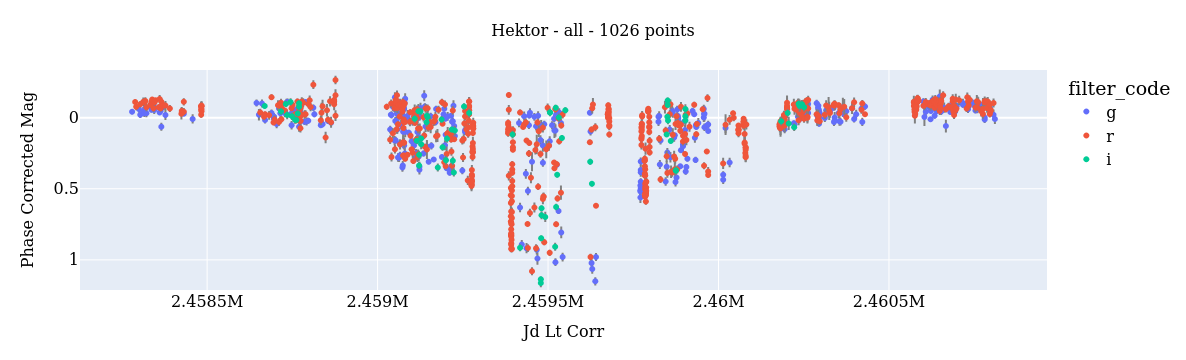

In [15]:
# Here is a plot to see if your linear fit worked for all the three filters. If they mismatch, you can go back and change parameters until they roughtly match each other.
plots.general(x_column='jd_lt_corr',
              y_column='phase_corrected_mag',
              show_yerr=True,
              show_color=True,
              color_column='filter_code',
              table=merged_table,
              # save_path=string+'_corrected_by_phase.jpg'
             )

# Periodic search - all data

In [17]:
P_ref=6.92
min_freq = [3.0,2]
max_freq = [4.0,6]
n_terms =  [2,2]
delta_t =  [None,None]# Not a fit, just to plot a vertical line in the periodogram
peaks =    [False,False]
n_shuffle = [10,None]
samples_per_peak = [None,None]
freq = []
power = []
f_win = []
p_win = []
rotational_analysis =[]

for i in range(len(n_terms)):
    ra = spintrace.RotationalAnalysis(table=merged_table,
                                               P_ref=P_ref,
                                               f_min=min_freq[i],
                                               f_max=max_freq[i],
                                               n_term=n_terms[i]) 
    f,p,fr,po = ra.lomb_scargle_fit(asteroid=body.name, 
                                         filter_code=None,
                                         use_magerr=True,
                                         delta_t = delta_t[i],
                                         legend=True,
                                         samples_per_peak=samples_per_peak[i],
                                         peaks = peaks[i],
                                         n_shuffle = n_shuffle[i],
                                         use_window_function=True,
                                         y_max = 0.4,
                                         save_path=string+'_periodogram'+str(i)+'.jpg'
                                        )
    freq.append(f)
    power.append(p)
    f_win.append(fr)
    p_win.append(po)
    rotational_analysis.append(ra)

/home/flavia/.local/lib/python3.13/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:134: RuntimeWarning:

invalid value encountered in divide

/home/flavia/.local/lib/python3.13/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:134: RuntimeWarning:

invalid value encountered in divide



In [18]:
rot = rotational_analysis[0]
24/rot.best_freq

np.float64(6.920248580395398)

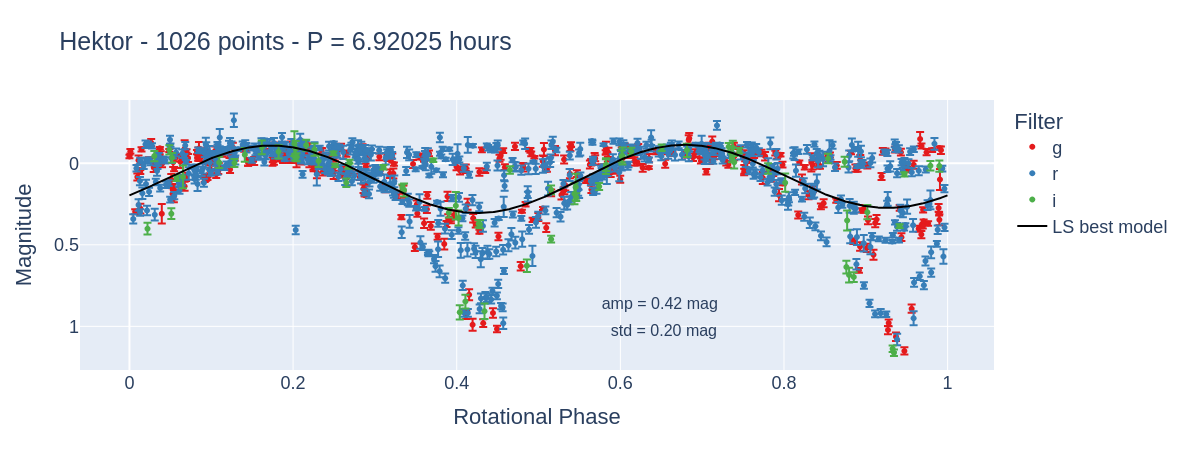

In [20]:
import numpy as np
model_params = rot.compute_phased_model(JD = np.array(rot.table['jd_lt_corr']), 
                                                        mag = np.array(rot.table['phase_corrected_mag']),
                                                        best_freq = rot.best_freq ,
                                                        epoch0=2458279.952216666 # 2018-06-10 10:51:12 first valid data point
                                                       )
            
df = plots.folded_lightcurve(asteroid=body.name,
                                table = rot.table,
                                filter_codes=np.array(rot.table['filter_code']),
                                JD=np.array(rot.table['jd_lt_corr']),  
                                model_params=model_params, 
                                corrected_mag=np.array(rot.table['phase_corrected_mag']),
                                mag_err=np.array(rot.table['mag_cal_err']),
                                best_freq = rot.best_freq, 
                                save_path=string+'_lightcurve_folded.jpg', 
                                epoch_zero = 2458279.952216666, # 2018-06-10 10:51:12 first valid data point
                                show_fig=True)

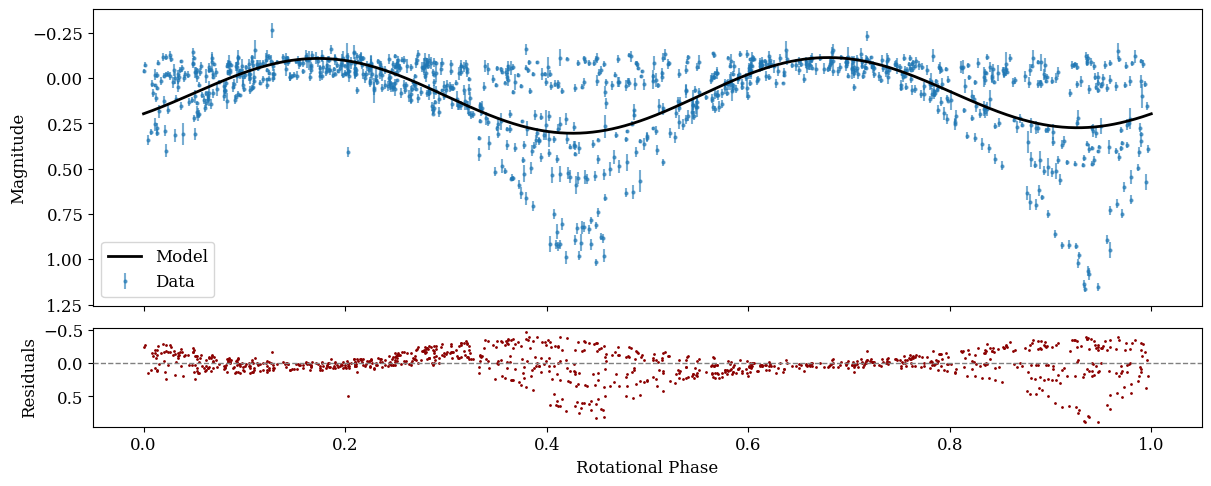

In [21]:
df['residuals'] = df['Magnitude']-df['model_mag']
plots.plot_folded_lightcurve_with_residuals(df,save_path=string+'folded_light_curve_with_residuals.jpg',fontsize=12)

# Single orbit analysis

This is useful for targets that present rotational light curve amplitude variation yearly, as for Hektor. 
The following lines: separate the data by orbits, search for the period and fit the rotational model in each sub-set of the data set (all filters together here). 
Then it plots all phased data and their respective models together, so you can see the light curve amplitude variation. 

In [23]:
# The gap_threshold is given in days (default is 90), it the gap used to separate one orbit from another.
samples = spintrace.split_table_by_time_gaps(merged_table, jd_column='jd_lt_corr', gap_threshold=90)
print(len(samples),'orbits found')

7 orbits found


In [27]:
# Here you will search for the best period in each subset and built a rotational light curve model for each one. 
# nt corresponds to the Fourier terms to be used in the LombScargle search, the list must have the same lenght as the orbits defined above. 
# You can run as many times you need until you get a satisfactory model for the orbit light curve, is an interactive procedure here. 
nt = [2,2,2,9,2,2,2]

rot, tab, folded_models,freq,power= spintrace.RotationalAnalysis.per_sample_analysis(asteroid=body.name,
                                    table=orbit_tables, # previously defined orbits
                                    nterms=nt,
                                    P_ref=6.92, # published rotational period in hours
                                    f_min=3.443, # minimum and maximum frequencies allowed to be explored during the search in cycles/day
                                    f_max=3.49,
                                    delta_t=(0.0014*3), # This error bar (hour) is not used in the search, it is plotted in the periodogram so you can have an idea of the width your peak has
                                    samples_per_peak=200, # This is a keyword of the LombScargle method, it means you will sample the main peak 300 times, and sometimes can reveal hidden frequencies. 
                                    use_window_function=False,
                                    # n_shuffle = 10,
                                    save_path=string)

Figure saved to Hektor/plots/Hektor_A_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_B_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_C_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_D_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_E_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_F_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_G_corrected_by_phase.jpg


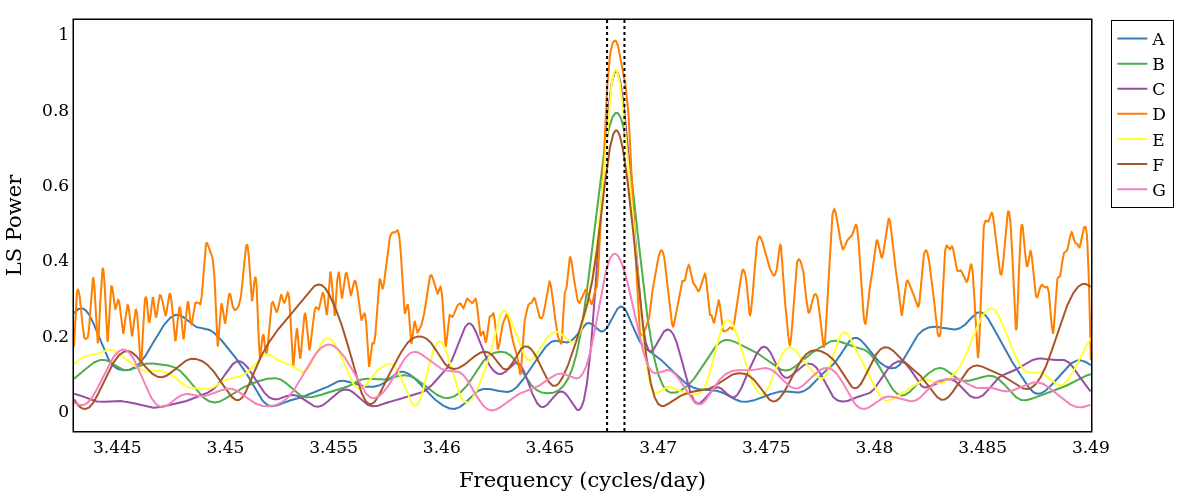

In [28]:
plots.plot_all_periodograms(frequency=freq,
                            power=power,
                            best_frequency=rot['E'].best_freq,
                            error=0.0008,
                            bkg=False,
                            fontsize=plots.fontsize+5,
                            save_path=string)

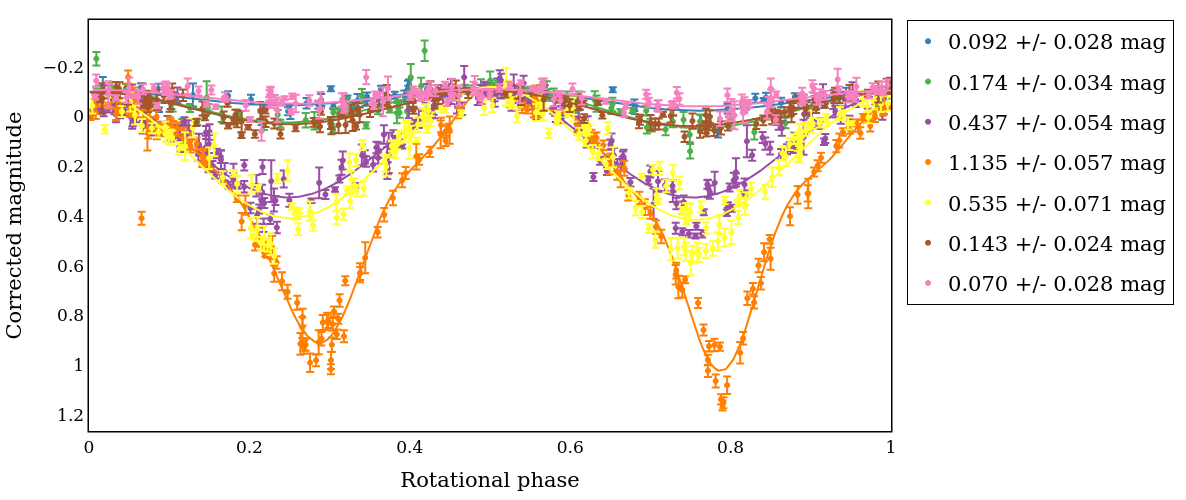

In [30]:
# Here you get an interactive plot will all fits together. You can download it as png by clicking in the first button in the right upper corner.
# To activate and deactivate the visualization of one model, just click on it in the legend.
plots.plot_all_folded_samples(folded_models,fontsize=plots.fontsize+5,save_path=string,rot_dict=rot)

In [31]:
# Here we merge all orbits together again. Now containing a column mag_corr_by_rot, wich is basically magnitude minus the rotational model in their respective orbits.
final_table = vstack([tab['A'],tab['B'],tab['C'],tab['D'],tab['E'],tab['F'],tab['G']])
len(final_table)

1026

In [32]:
# Then we fit the phase curves again to obtain H and G values free of any rotational amplitude variations
for item in f_list:
    # creates the general plots of reduced mag as a function of time (JD corrected by light time).
    plots.general(filter_code=item,
              show_yerr=True,
              show_color=True,
              table=final_table,
              y_column='mag_corr_by_rot',
              save_path=string+'_general_'+item+'_corr.jpg')
    # Fit the phase curve and create the plots
    popt, fit_label, popt2, fit_label_binned = mpa.fit_phase_curve(filter_code=item,
                                                                   phase_bin=phase_bin,
                                                                   table=final_table,
                                                                   model=model)
    plots.phase_curve(filter_code=item,
                  popt=popt, 
                  fit_label=fit_label, 
                  popt2=popt2, 
                  fit_label_binned=fit_label_binned,
                  show_yerr=True,
                  show_color=True,
                  show_fig = False,
                  table=final_table,
                  y_column='mag_corr_by_rot',
                  save_path=string+'_phase_curve_'+item+'_'+model+'_corr.jpg')

Figure saved to Hektor/plots/Hektor_general_g_corr.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_g_linear_corr.jpg
Figure saved to Hektor/plots/Hektor_general_r_corr.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_r_linear_corr.jpg
Figure saved to Hektor/plots/Hektor_general_i_corr.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_i_linear_corr.jpg


In [33]:
# Check the 'Hektor_phase_curve*corr.jpg' plots and chose with values you wanna use to correct data for solar phase angle
table_g_corr = mpa.fit_phase_curve(table=final_table,filter_code='g',model='linear',H=7.84,G=0.04)
table_i_corr = mpa.fit_phase_curve(table=final_table,filter_code='i',model='linear',H=7.11,G=0.04)
table_r_corr = mpa.fit_phase_curve(table=final_table,filter_code='r',model='linear',H=7.36,G=0.04)

Fit result for g filter using original data and linear model:
Original data linear fit: H = 7.84, G = 0.04
Fit result for i filter using original data and linear model:
Original data linear fit: H = 7.11, G = 0.04
Fit result for r filter using original data and linear model:
Original data linear fit: H = 7.36, G = 0.04


In [34]:
# join everything again
merged_table_corr = vstack([table_g_corr, table_r_corr, table_i_corr])
len(merged_table_corr)

1026

Figure saved to Hektor/plots/Hektor_corrected_by_phase_and_rotation.jpg


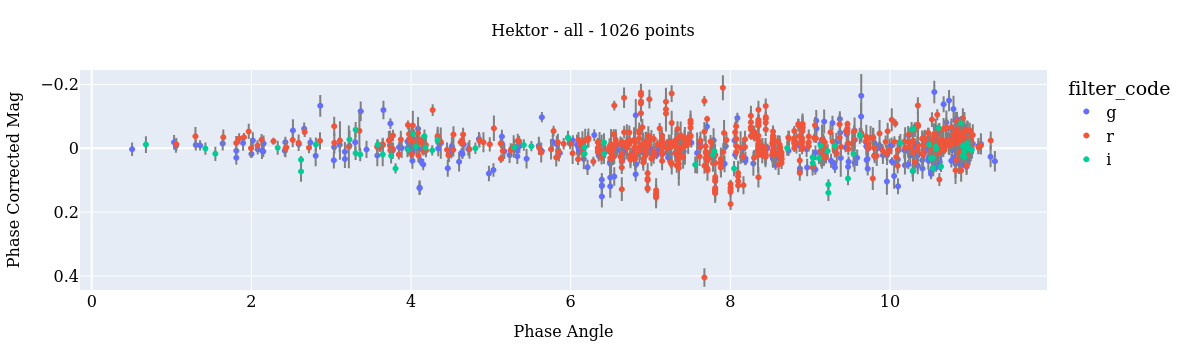

In [35]:
# Now you can see the residuals after discounting the rotational effects (orbit by orbit) and the solar phase angle effects. 
plots.general(x_column='phase_angle',
              y_column='phase_corrected_mag',
              show_yerr=True,
              show_color=True,
              color_column='filter_code',
              table=merged_table_corr,
              save_path=string+'_corrected_by_phase_and_rotation.jpg')

Figure saved to Hektor/plots/Hektor_corrected_by_phase_and_rotation_final.jpg


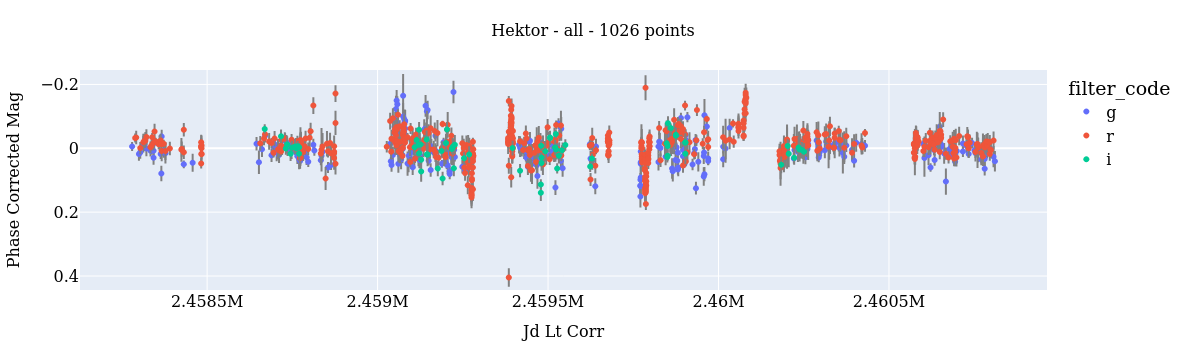

In [36]:
plots.general(x_column='jd_lt_corr',
              y_column='phase_corrected_mag',
              show_yerr=True,
              show_color=True,
              color_column='filter_code',
              table=merged_table_corr,
              save_path=string+'_corrected_by_phase_and_rotation_final.jpg')

In [35]:
rotational_analysis2 = ZTFrc.RotationalAnalysis(table=merged_table_corr, P_ref=(2.9651*24),f_min=0.001,f_max=12,n_term=2)
len(rotational_analysis2.table)

1026

In [37]:
a,b,c,d = rotational_analysis2.lomb_scargle_fit(
    asteroid='Skamandrios', 
    filter_code=None,
    use_magerr=True,
    save_path=string+'_Skamandrios_periodogram_broad.jpg',
    legend=True, 
    # samples_per_peak=400,
    peaks=True, 
    pn=2,
    y_max=0.2,
    n_shuffle=10,
    use_window_function=True,
    table=rotational_analysis2.table)

/home/flavia/.local/lib/python3.13/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:134: RuntimeWarning:

invalid value encountered in divide



1: Period = 23.924506 hours, Power = 0.138256
2: Period = 24.013419 hours, Power = 0.114567


In [38]:
rot.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G'])

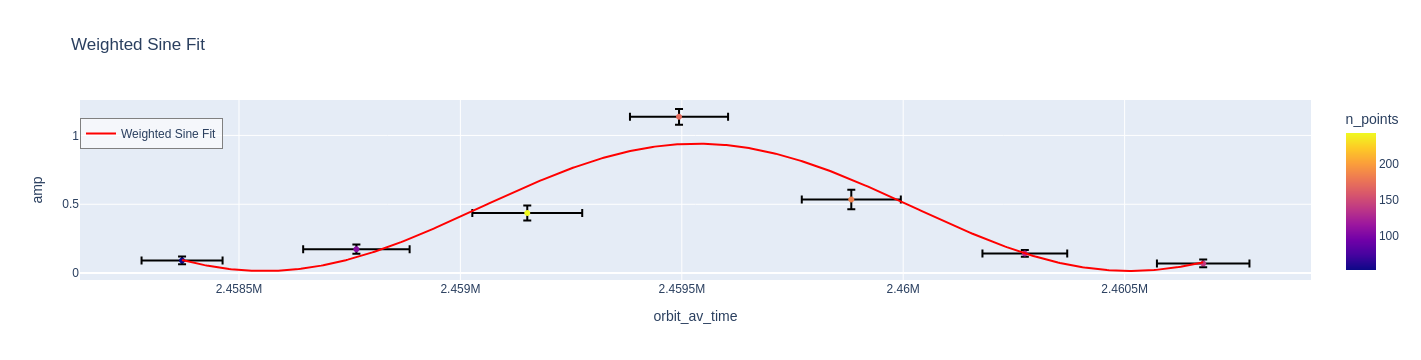

In [39]:
t_av = []
t_err = []
p = []
amp = []
amp_err = []
n_points = []
for i, key in enumerate(rot.keys()):
    m = orbit_tables[i]['jd_lt_corr'].mean()
    e = orbit_tables[i]['jd_lt_corr'].mean() - orbit_tables[i]['jd_lt_corr'].min()
    pp = 24/rot[key].best_freq
    a = round(rot[key].amplitude,3)
    ae = round(rot[key].std_model_residuals,3)
    n = len(rot[key].table)
    t_av.append(m)
    t_err.append(e)
    p.append(pp)
    amp.append(a)
    amp_err.append(ae)
    n_points.append(n)
    

df = pd.DataFrame({
    'orbit_av_time': t_av,
    'orbit_av_time_err': t_err,
    'amp': amp,
    'amp_err': amp_err,
    'n_points': n_points
})


ZTFrc.fit_weighted_sine(df, time_col='orbit_av_time', mag_col='amp', mag_err_col='amp_err',
                      time_err_col='orbit_av_time_err', color_col='n_points', title='Weighted Sine Fit')

In [40]:
# # Stephens 2014
# new_row = pd.DataFrame([{
#     "orbit_av_time": 2456763.614771,
#     "orbit_av_time_err": 1,
#     "amp":0.29,
#     "amp_err":0.02,
#     "n_points": 0
# }])

# df = pd.concat([df, new_row], ignore_index=True)



In [41]:
# Stephens 2020
new_row = pd.DataFrame([{
    "orbit_av_time": 2458680.820932,
    "orbit_av_time_err": 12,
    "amp":0.15,
    "amp_err":0.01,
    "n_points": 0
}])

df = pd.concat([df, new_row], ignore_index=True)



In [42]:
# Stephens 2022
new_row = pd.DataFrame([{
    "orbit_av_time": 2459463.760334,
    "orbit_av_time_err": 2,
    "amp":1.2,
    "amp_err":0.01,
    "n_points": 0
}])

df = pd.concat([df, new_row], ignore_index=True)



In [43]:
# Farfan 2024
new_row = pd.DataFrame([{
    "orbit_av_time": 2459949.5,
    "orbit_av_time_err": 7,
    "amp":0.46,
    "amp_err":0.02,
    "n_points": 0
}])

df = pd.concat([df, new_row], ignore_index=True)



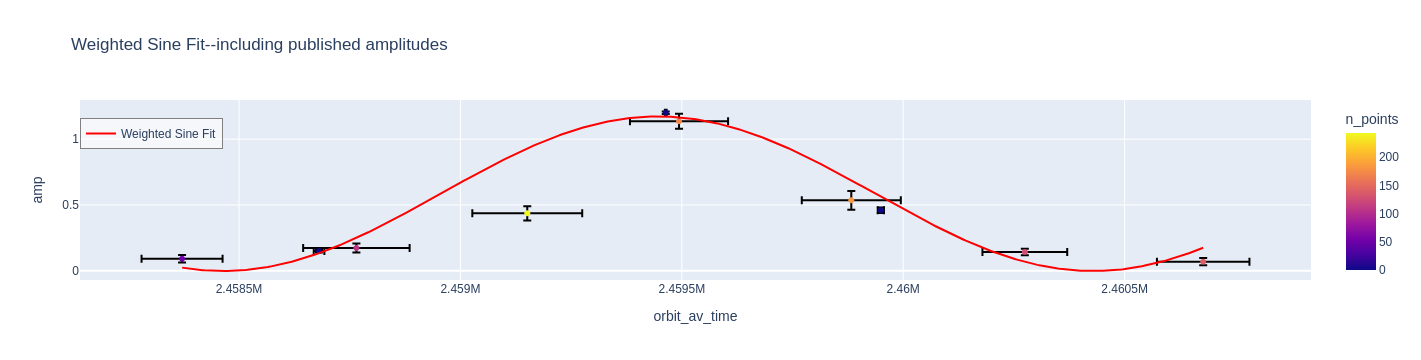

In [44]:
ZTFrc.fit_weighted_sine(df, time_col='orbit_av_time', mag_col='amp', mag_err_col='amp_err',
                      time_err_col='orbit_av_time_err', color_col='n_points', title='Weighted Sine Fit--including published amplitudes')

In [ ]:
Ps = np.array(p)

var = round(Ps.max()-Ps.min(),4)*60*60
median = np.median(Ps)
dif = round((6.92-median)*60*60,1)
print('Median of the yearly synodic periods:', median,'hours')
print('Synodic rotational period variation of',var,'seconds')
print('Difference from published period of',dif, 'seconds')

In [ ]:
for k in Ps:
    delta = round(k-median,4)
    print('{:3f}'.format(delta),' hours')

In [ ]:
P_ast = 4425.852513990207  # orbital period of the asteroid (days) from SBDB
P_earth = 365.256          # orbital period of Earth (days) from https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html

# Relative period between asteroid and Earth
P_rel = 1 / abs((1 / P_earth) - (1 / P_ast))  # in days
P_syn = median / 24  # convert hours to days

# For prograde rotation
P_sid = 1 / ((1 / P_syn) + (1 / P_rel))  # sidereal period in days

P_sid_hours = P_sid * 24

s1 = round((P_sid_hours-6.92051)*60*60,3) #Hung2022

print('My sidereal P is:',round(P_sid_hours,5),'hours')
print('Difference from ssocard sidereal periods:',s1,'seconds')

In [ ]:
path = 'Hektor/'
rotational_analysis = ZTFrc.RotationalAnalysis(table=merged_table, path=path,P_ref=6.928,f_min=3.05,f_max=4.5,n_term=2) 
len(rotational_analysis.table)

In [ ]:
rotational_analysis.lomb_scargle_fit(asteroid='Hektor', 
                                     filter_code=None,
                                     use_magerr=True,
                                     save_path=path,
                                     # ,delta_t = 0.00015,
                                     # legend=True,
                                     samples_per_peak=200
                                    )

In [ ]:
24/(rotational_analysis.best_freq)

In [ ]:
import numpy as np 

f = np.array(rotational_analysis.table['filter_code'])
jd = np.array(rotational_analysis.table['jd_lt_corr'])
corrected_mag = np.array(rotational_analysis.table['phase_corrected_mag'])
mag_err = np.array(rotational_analysis.table['mag_cal_err'])
best_freq = rotational_analysis.best_freq.value

model_params = rotational_analysis.compute_phased_model(jd, 
                                                        corrected_mag,
                                                        best_freq, 
                                                        # epoch0=2459949.6145833
                                                       )

In [ ]:
df_final = plots.folded_lightcurve(asteroid='Hektor',
                        table = rotational_analysis.table,
                        filter_codes=f,
                        JD=jd, 
                        # epoch_zero=2459949.6145833,
                        model_params=model_params, 
                        corrected_mag=corrected_mag,
                        mag_err=mag_err, 
                        best_freq = best_freq, 
                        save_path='Hektor/Hektor_folded_lightcurve_zoom.jpg', 
                        shev = None)

In [ ]:
tab = rotational_analysis.get_detrended_magnitudes()
tab.columns

In [ ]:
plots.general(filter_code='g',
              show_yerr=True,
              show_color=True,
              table=tab,
              y_column='mag_corr_by_rot',
              save_path='Hektor/Hektor_general_g_corr.jpg')

Figure saved to Hektor/Hektor_general_r_corr.jpg


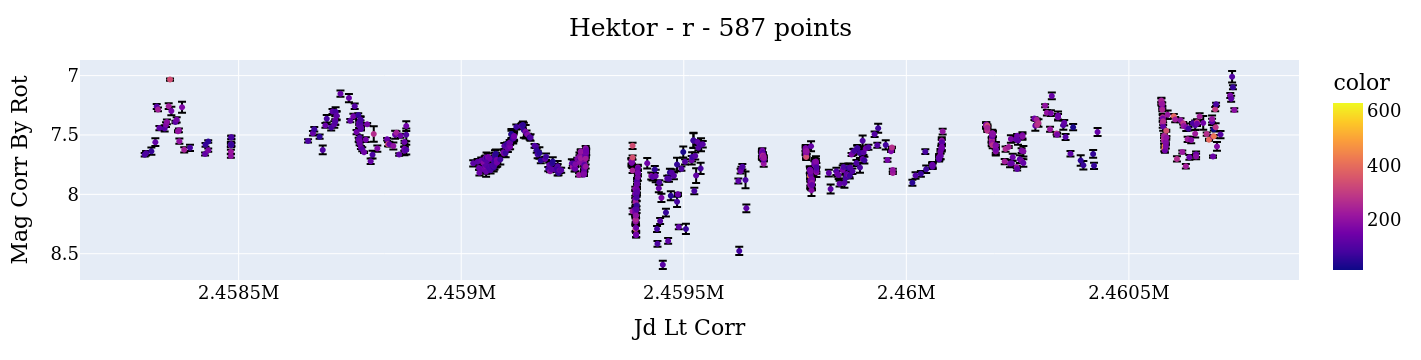

In [34]:
plots.general(filter_code='r',
              show_yerr=True,
              show_color=True,
              table=tab,#rotational_analysis.table,
              y_column='mag_corr_by_rot',
              save_path='Hektor/Hektor_general_r_corr.jpg')

Figure saved to Hektor/Hektor_general_i_corr.jpg


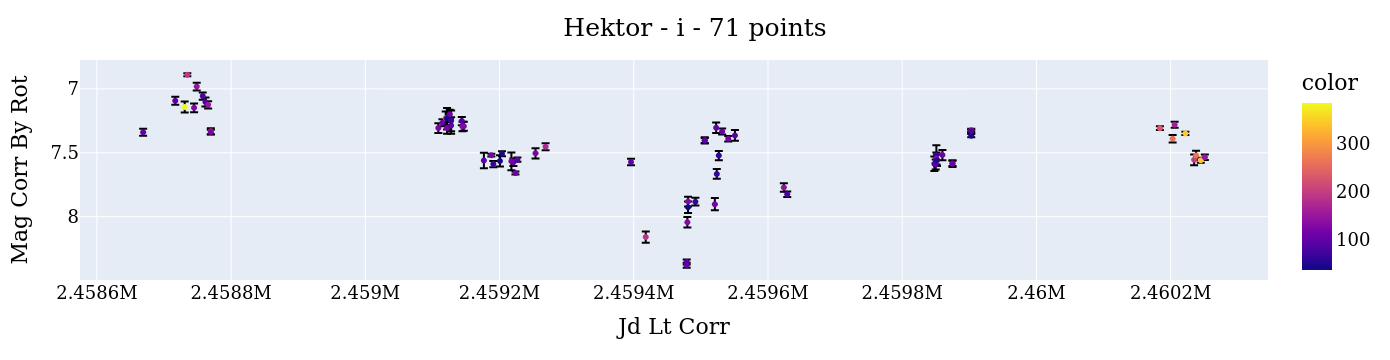

In [35]:
plots.general(filter_code='i',
              show_yerr=True,
              show_color=True,
              table=tab,#rotational_analysis.table,
              y_column='mag_corr_by_rot',
              save_path='Hektor/Hektor_general_i_corr.jpg')

## Amplitude variation identified. 

# End